# Gradient boosting model

One, two, you know what to do...

## Notebook set up

### Imports

In [ ]:
# Standard library imports
from itertools import combinations, permutations
from pathlib import Path

# Third party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

### Data loading

In [2]:
train_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv'

# Load the training dataset
train_df = pd.read_csv(train_df_path)

# Display first few rows of training data
train_df.head().transpose()

,0,1,2,3,4
id,0,1,2,3,4
age,31,50,32,54,54
alcohol_consumption_per_week,1,2,3,3,1
physical_activity_minutes_per_week,45,73,158,77,55
diet_score,7.7,5.7,8.5,4.6,5.7
sleep_hours_per_day,6.8,6.5,7.4,7.0,6.2
screen_time_hours_per_day,6.1,5.8,9.1,9.2,5.1
bmi,33.4,23.8,24.1,26.6,28.8
waist_to_hip_ratio,0.93,0.83,0.83,0.83,0.9
systolic_bp,112,120,95,121,108


In [3]:
# Display dataset information (columns, dtypes, non-null counts)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

## 1. Data Preprocessing

In [4]:
# Drop ID column
train_df.drop(columns=['id'], inplace=True)

print(f'ID column removed')
print(f'Remaining columns: {list(train_df.columns)}')

ID column removed
Remaining columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


## 2. Preprocessing

### 2.1. Column definitions

In [5]:
# Define the label
label = 'diagnosed_diabetes'

# Define numerical features to apply IQR clipping
numerical_features = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
]

# Define ordinal features to encode
ordinal_features = ['education_level', 'income_level']

# Define ordinal categories in order
education_categories = [['No formal', 'Highschool', 'Graduate', 'Postgraduate']]
income_categories = [['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']]

# Define features for one-hot encoding
nominal_features = [
    'gender', 'ethnicity', 'smoking_status', 'employment_status',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history'
]

### 2.2. Ordinal encoding

In [6]:
# Create ordinal encoder with categories
ordinal_encoder = OrdinalEncoder(
    categories=education_categories + income_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

# Fit and transform ordinal features
ordinal_encoded = ordinal_encoder.fit_transform(train_df[ordinal_features])
train_df[ordinal_features] = ordinal_encoded

# Remove original ordinal features and add encoded versions
train_df.drop(columns=ordinal_features, inplace=True)

### 2.3. Nominal encoding

In [7]:
# Create one-hot encoder
onehot_encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

# Convert encoded features to DataFrame
encoded_features_df = pd.DataFrame(
    onehot_encoder.fit_transform(train_df[nominal_features]),
    columns=onehot_encoder.get_feature_names_out(nominal_features)
)

# Remove original nominal features and add encoded versions
train_df = pd.concat([train_df.drop(columns=nominal_features), encoded_features_df], axis=1)

## 3. Feature engineering

In [8]:
features = train_df.drop(columns=[label]).columns.tolist()
new_features = {}

### 3.1. Difference features

In [9]:
for feature_a, feature_b in combinations(features, 2):
    feature_name = f'{feature_a}-{feature_b}'
    new_features[feature_name] = train_df[feature_a] - train_df[feature_b]

### 3.2. Sum features

In [10]:
for feature_a, feature_b in combinations(features, 2):
    feature_name = f'{feature_a}+{feature_b}'
    new_features[feature_name] = train_df[feature_a] + train_df[feature_b]

### 3.3. Ratio features

In [11]:
for feature_a, feature_b in permutations(features, 2):
    feature_name = f'{feature_a}/{feature_b}'
    new_features[feature_name] = train_df[feature_a] / (train_df[feature_b] + train_df[feature_b].min() + 1)

### 3.4. Reciprocal features

In [12]:
for feature in features:
    feature_name = f'1/{feature}'
    new_features[feature_name] = 1 / (train_df[feature] + train_df[feature].min() + 1)

### 3.5. Log features

In [13]:
for feature in features:
    feature_name = f'log{feature}'
    new_features[feature_name] = np.log(train_df[feature] + train_df[feature].min() + 1)

### 3.6. Square root features

In [14]:
for feature in features:
    feature_name = f'root{feature}'
    new_features[feature_name] = (train_df[feature] + train_df[feature].min() + 1) ** (1/2)

### 3.7. Square features

In [15]:
for feature in features:
    feature_name = f'root{feature}'
    new_features[feature_name] = (train_df[feature] + train_df[feature].min() + 1) ** 2

### 3.6. Add new features

In [16]:
train_df = pd.concat([train_df, pd.DataFrame(new_features)], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Columns: 1741 entries, age to rootcardiovascular_history_1
dtypes: float64(1631), int64(110)
memory usage: 9.1 GB


## 4. Model training and optimization

### 4.0. Baseline model performance

In [ ]:
# Create baseline model with default parameters
baseline_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectPercentile(percentile=10)),
    ('classifier', HistGradientBoostingClassifier())
])

# Estimate AUC with cross-validation
baseline_scores = cross_val_score(
    baseline_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3,
    scoring=make_scorer(roc_auc_score)
)

print(f'Baseline model cross-validation mean AUC: {np.mean(baseline_scores):.4f}')

Baseline model (unoptimized):
Mean AUC: 0.6239
Std AUC: 0.0005

CPU times: user 13min 43s, sys: 32.9 s, total: 14min 15s
Wall time: 6min


### 4.1. Hyperparameter optimization with RandomizedSearchCV

In [ ]:
%%time

from scipy.stats import uniform, randint, loguniform

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectPercentile(percentile=10)),
    ('classifier', HistGradientBoostingClassifier(random_state=315))
])

# Best run: 0.6305
#   feature_selector__percentile: 25
#   classifier__validation_fraction: 0.1
#   classifier__n_iter_no_change: 20
#   classifier__min_samples_leaf: 10
#   classifier__max_iter: 250
#   classifier__max_depth: 15
#   classifier__max_bins: 128
#   classifier__learning_rate: 0.15
#   classifier__l2_regularization: 10.0
#   classifier__early_stopping: False

# Define parameter distributions for randomized search
param_distributions = {
    'feature_selector__percentile': [25],                      # 5 to 30 inclusive
    'classifier__learning_rate': loguniform(0.001, 0.3),       # Log-uniform between 0.001 and 0.3
    'classifier__max_iter': randint(100, 501),                 # 50 to 300 inclusive
    'classifier__max_depth': [10, 15, 20, 25 None],            # Keep discrete choices including None
    'classifier__min_samples_leaf': randint(5, 51),            # 5 to 50 inclusive
    'classifier__l2_regularization': loguniform(1e-4, 100.0),  # Log-uniform from 0.0001 to 10
    'classifier__max_bins': [64, 128, 255],                    # Keep binary choice
    'classifier__early_stopping': [True],                      # Always True
    'classifier__validation_fraction': [0.1],                  # Uniform between 0.05 and 0.30
    'classifier__n_iter_no_change': [30]                       # 5 to 20 inclusive
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Number of random combinations to try
    cv=3,
    scoring='roc_auc',
    n_jobs=1,
    random_state=315,
    verbose=0
)

# Fit the randomized search
sample_df = train_df.sample(n=100000, random_state=315)

random_search.fit(
    sample_df.drop(columns=['diagnosed_diabetes']),
    sample_df['diagnosed_diabetes']
)

print(f'\nBest cross-validation score (ROC-AUC): {random_search.best_score_:.4f}')
print(f'\nBest parameters:')

for param, value in random_search.best_params_.items():
    print(f'  {param}: {value}')

print()

Starting hyperparameter optimization...
Testing 100 random parameter combinations
Using 3-fold cross-validation
Scoring metric: roc_auc


Optimization complete in 20736.5 seconds (345.6 minutes)

Best cross-validation score (ROC-AUC): 0.7220

Best parameters:
  feature_selector__percentile: 25
  classifier__validation_fraction: 0.1
  classifier__n_iter_no_change: 20
  classifier__min_samples_leaf: 10
  classifier__max_iter: 250
  classifier__max_depth: 15
  classifier__max_bins: 128
  classifier__learning_rate: 0.15
  classifier__l2_regularization: 10.0
  classifier__early_stopping: False


### 4.2. Evaluate optimized model

In [ ]:
# Get the best model from random search
best_model = random_search.best_estimator_

# Evaluate with cross-validation to verify performance
scores = cross_val_score(
    best_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=5,
    scoring=make_scorer(roc_auc_score),
    n_jobs=-1
)

print(f'Optimized model cross-validation mean AUC: {np.mean(scores):.4f}')

Optimized model cross-validation results (5-fold):
Mean AUC: 0.6306
Std AUC: 0.0004
Min AUC: 0.6302
Max AUC: 0.6313
CPU times: user 6.07 s, sys: 5.96 s, total: 12 s
Wall time: 6min 41s


### 4.3. Train final model on full dataset

In [ ]:
# Train the final model on the full dataset
final_model = random_search.best_estimator_

final_model.fit(
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes']
)

Final model trained on full dataset
Training samples: 700,000
Features after preprocessing: 435
CPU times: user 13min 8s, sys: 11 s, total: 13min 19s
Wall time: 2min 18s


### 4.4. Compare baseline vs optimized performance

/tmp/ipykernel_542566/2894082424.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


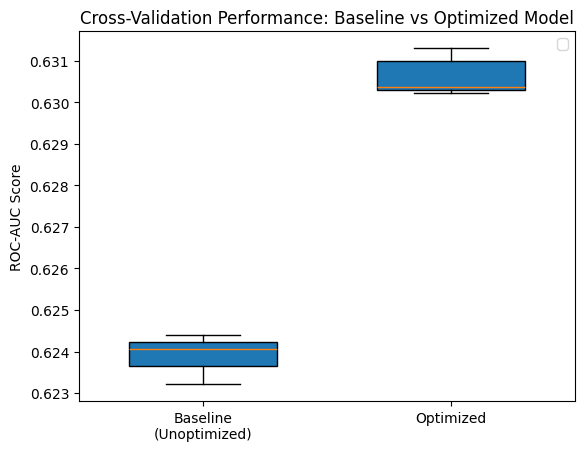

Baseline  - Mean: 0.6239, Std: 0.0005
Optimized - Mean: 0.6306, Std: 0.0004
Improvement: 0.67%


In [ ]:
# Prepare data for boxplot
comparison_data = [baseline_scores, scores]
labels = ['Baseline\n(Unoptimized)', 'Optimized']

# Create boxplot
plt.title('Cross-Validation Performance')
plt.boxplot(comparison_data, tick_labels=labels, patch_artist=True, widths=0.6)
plt.ylabel('ROC-AUC Score')
plt.show()

# Print summary statistics
print(f'Baseline  - Mean: {np.mean(baseline_scores):.4f}, Std: {np.std(baseline_scores):.4f}')
print(f'Optimized - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}')
print(f'Improvement: {improvement:.2f}%')

### 4.5. Confusion matrices

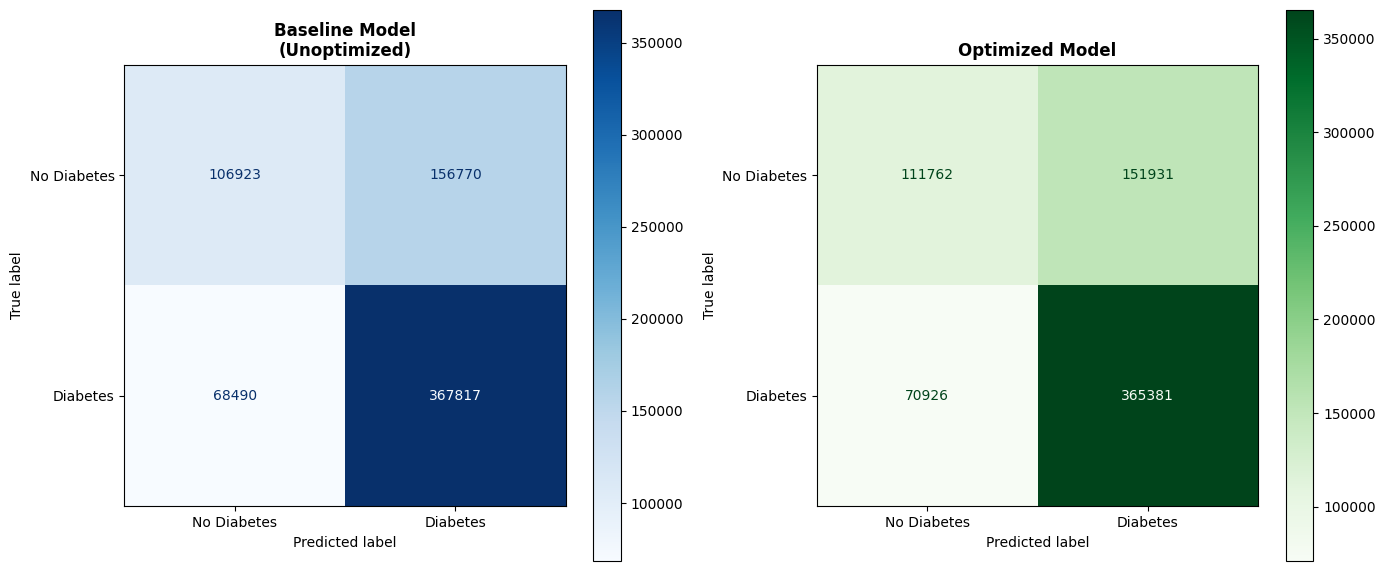


Confusion Matrix Metrics:
Metric          Baseline        Optimized       Difference     
----------------------------------------------------------------------
Accuracy        0.6782          0.6816          +0.0034         
Precision       0.7012          0.7063          +0.0052         
Recall          0.8430          0.8374          -0.0056        
F1-Score        0.7656          0.7663          +0.0007         
Specificity     0.4055          0.4238          +0.0184         


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

# Get predictions for both models using cross-validation
baseline_predictions = cross_val_predict(
    baseline_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=3
)

optimized_predictions = cross_val_predict(
    final_model,
    train_df.drop(columns=['diagnosed_diabetes']),
    train_df['diagnosed_diabetes'],
    cv=5
)

# Create confusion matrices
baseline_cm = confusion_matrix(train_df['diagnosed_diabetes'], baseline_predictions)
optimized_cm = confusion_matrix(train_df['diagnosed_diabetes'], optimized_predictions)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=['No Diabetes', 'Diabetes'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model\n(Unoptimized)', fontsize=12, fontweight='bold')

# Optimized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=optimized_cm, display_labels=['No Diabetes', 'Diabetes'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Optimized Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate and display metrics for both models
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return accuracy, precision, recall, f1, specificity

baseline_metrics = calculate_metrics(baseline_cm)
optimized_metrics = calculate_metrics(optimized_cm)

print('\nConfusion Matrix Metrics:')
print('=' * 70)
print(f'{"Metric":<15} {"Baseline":<15} {"Optimized":<15} {"Difference":<15}')
print('-' * 70)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
for name, base, opt in zip(metric_names, baseline_metrics, optimized_metrics):
    diff = opt - base
    sign = '+' if diff >= 0 else ''
    print(f'{name:<15} {base:<15.4f} {opt:<15.4f} {sign}{diff:<15.4f}')

## 5. Save Model

In [23]:
# Define model directory and ensure it exists
model_dir = Path('../models')
model_dir.mkdir(parents=True, exist_ok=True)

# Create model filename
model_name = 'gradient_boosting'
model_path = model_dir / f'{model_name}.joblib'

# Save the final model
joblib.dump(final_model, model_path)
print('Model saved to:', model_path)
print(f'File size: {model_path.stat().st_size / (1024**2):.2f} MB')

Model saved to: ../models/gradient_boosting.joblib
File size: 1.39 MB


## 6. Save model description

In [24]:
# Create model description filename
markdown_path = model_dir / f'{model_name}.md'

# Create markdown description
markdown_content = f"""# Logistic Regression Model for Diabetes Prediction

## Model overview

This dataset contains a scikit-learn Pipeline object that chains together multiple preprocessing, feature engineering, and modeling steps into a single estimator. Pipelines ensure that all transformations are applied consistently during both training and inference, preventing data leakage and simplifying deployment. The pipeline was optimized using RandomizedSearchCV. Optimized hyperparameters are marked with *[optimized]* in the pipeline component descriptions below.

For details on model optimization and training, see the [logistic regression optimization and training notebook](https://github.com/gperdrizet/diabetes-prediction/blob/main/notebooks/01.1-logistic_regression_model.ipynb) on GitHub.

## Files

- **Model file**: `{model_path.name}` (scikit-learn Pipeline object serialized with joblib)
- **Custom transformers**: `logistic_regression_transformers.py` (required for model deserialization)
- **Documentation**: `{markdown_path.name}`

Key features:
- **End-to-end processing**: Automatically handles all preprocessing from raw data to predictions
- **Reproducible transformations**: All fitted parameters (scalers, encoders, PCA components) are preserved
- **Hyperparameter optimization**: Parameters across all pipeline steps were jointly optimized

## Training information

- **Training date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Training samples**: {len(train_df):,}
- **Cross-validation score (ROC-AUC)**: {random_search.best_score_:.4f}

## Hyperparameter optimization

- **Method**: Randomized Search CV
- **Cross-validation folds**: {CV_FOLDS}
- **Iterations**: {optimal_n_iter}
- **Scoring metric**: ROC-AUC
- **Optimization runtime**: {optimization_time:.1f} seconds ({optimization_time/60:.1f} minutes)

## Inference performance

Measured on test dataset with {len(test_df):,} samples using `tracemalloc` to track peak memory allocation:

- **Inference time**: {inference_time:.4f} seconds
- **Throughput**: {samples_per_second:,.0f} samples/second
- **Peak memory**: {memory_footprint_gb:.4f} GB

## Pipeline components

### 1. Preprocessing

#### ID column removal
- **ID column dropper**: Automatically removes the 'id' column from input data (custom transformer)

#### Numerical features
- **Standardization**: Standard scaling (mean=0, std=1)
- **Features**: age, alcohol_consumption_per_week, diet_score, physical_activity_minutes_per_week, sleep_hours_per_day, screen_time_hours_per_day, bmi, waist_to_hip_ratio, systolic_bp, diastolic_bp, heart_rate, cholesterol_total, hdl_cholesterol, ldl_cholesterol, triglycerides

#### Ordinal features
- **Ordinal encoding**: education_level, income_level

#### Nominal features
- **One-hot encoding**: gender, ethnicity, smoking_status, employment_status, family_history_diabetes, hypertension_history, cardiovascular_history (drop first category)

### 2. Feature engineering

- **Polynomial features**:
  - Degree: {random_search.best_params_.get('poly__degree', 'N/A')} *[optimized]*
  - Include bias: {random_search.best_params_.get('poly__include_bias', 'N/A')} *[optimized]*
  - Interaction only: {random_search.best_params_.get('poly__interaction_only', 'N/A')} *[optimized]*

- **Constant feature removal**: Removes features with zero variance (custom transformer)

- **Post-polynomial standardization**: Standard scaling after polynomial transformation

- **PCA dimensionality reduction**:
  - Components: {random_search.best_params_.get('pca__n_components', 'N/A')} *[optimized]*
  - SVD solver: {random_search.best_params_.get('pca__svd_solver', 'N/A')} *[optimized]*
  - Whiten: {random_search.best_params_.get('pca__whiten', 'N/A')} *[optimized]*

### 3. Classifier

- **Algorithm**: Logistic regression
- **Penalty**: {random_search.best_params_.get('logit__penalty', 'N/A')} *[optimized]*
- **Regularization (C)**: {f"{random_search.best_params_.get('logit__C'):.4f}" if random_search.best_params_.get('logit__C') is not None else 'N/A'} *[optimized]*
- **Max iterations**: {random_search.best_params_.get('logit__max_iter', 'N/A')}
- **Class weight**: {random_search.best_params_.get('logit__class_weight', 'N/A')}

## Custom transformers

The model uses two custom scikit-learn transformers defined in `logistic_regression_transformers.py`:

### IDColumnDropper
Automatically removes the 'id' column from input DataFrames before processing. This allows the model to accept raw test data without manual preprocessing.

### ConstantFeatureRemover
Removes features with zero variance after polynomial transformation. This eliminates redundant features that don't contribute to model predictions, reducing dimensionality and improving computational efficiency.

**Important**: The `logistic_regression_transformers.py` file must be available in the Python path when loading the model, as joblib stores references to these classes and needs to import them during deserialization.

## Usage

```python
import joblib
import pandas as pd
import sys
from pathlib import Path

# Add the models directory to the path (adjust as needed)
sys.path.insert(0, str(Path('models').resolve()))

# Load the model (this will import the custom transformers)
model = joblib.load('models/{model_path.name}')

# Prepare test data (pipeline will automatically handle 'id' column)
X_test = pd.read_csv('test.csv')

# Make predictions
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)
```

## Notes

- Input data can include the 'id' column - it will be automatically removed by the pipeline
- The pipeline handles all preprocessing and feature engineering automatically
- The `logistic_regression_transformers.py` file must be in the Python path when loading the model
"""

with open(markdown_path, 'w') as f:
    f.write(markdown_content)

print('Model description saved to:', markdown_path)

NameError: name 'CV_FOLDS' is not defined